### ![title](https://thermal-engineering.org/wp-content/uploads/2019/05/Navier-Stokes-Equations-definition.png)



![title](https://pbs.twimg.com/media/DT_gfgyX0AA6jzt.jpg)

# Simulateur de fluide en 2D dans une cavité
Basé sur **Numerical Simulation in Fluid Dynamics** édité par SIAM
On simule ici les équations de Navier-Stokes dans une cavité en 2D.

Les équations sont, pour la vitesse horizontale $u$ et la vitesse verticale $v$:

$\frac{\partial u}{\partial t} +\frac{\partial u^2}{\partial x} + \frac{\partial uv}{\partial y} = \frac{1}{\rho} \frac{\partial p}{\partial x} + g_x + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$

$\frac{\partial v}{\partial t} +\frac{\partial v^2}{\partial y} + \frac{\partial uv}{\partial x} = \frac{1}{\rho} \frac{\partial p}{\partial y} + g_x + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)$ 

(conservation de la quantité de mouvement)

$\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}=0$ (conservation de la masse)

In [1]:
import numpy as np
import numpy.linalg as alg
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
nu = 1e-5 # m^2/s
rho = 1000 # kg / m^3
g = 9.81
gx = 0
gy = -g # m/s^2

### Initialisation des constantes

In [6]:
tf = 1 # l'instant final max
n = 15 # nombre d'étapes de temps max de la simulation
dt = tf/n # quantité amenée à changer

t = 0

a = .1 # largeur en mètres de la boîte selon Ox
b = .1 # hauteur en mètres de la boîte selon Oy

imax = 5 # nombre de cases en espace selon Ox
jmax = 5 # nombre de cases en espace selon Oy
s = imax*jmax

dx = a/imax
dy = b/jmax # les indices 0 et jmax+1 sont réservés aux frontières extérieures à la boîte

print("taille de la matrice du système linéaire",s*s)

taille de la matrice du système linéaire 625


### Initialisation de la matrice du système linéaire pour le laplacien

In [19]:
# matrice du laplacien pour trouver la pression

def carre2vec(i,j): # entrées indicées à partir de 1
    return imax*(j-1)+i-1 # sortie indicée à partir de 0 (pour python)

S = np.zeros(shape=(s,s),dtype=float)

for i in range(1,imax+1):     # jusqu'à imax
    for j in range(1,jmax+1): # jusqu'à jmax
        k = carre2vec(i,j)
        S[k][k] += (-2/dx**2-2/dy**2)
        if j<jmax:
            S[k][carre2vec(i,j+1)] += 1/dy**2
        if j>1:
            S[k][carre2vec(i,j-1)] += 1/dy**2
        if i<imax:
            S[k][carre2vec(i+1,j)] += 1/dx**2
        if i>1:
            S[k][carre2vec(i-1,j)] += 1/dx**2
            
Si = alg.inv(S) # ne pas le faire si S est trop grande ! typiquement à partir de imax ~jmax ~60 on arrête

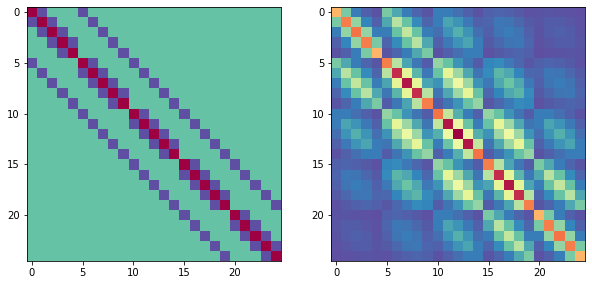

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
imf = ax[0].imshow(S, cmap='Spectral')
ime = ax[1].imshow(Si, cmap='Spectral')# on regarde la matrice S

###  Initialisation des tableaux de stockage

In [9]:
# tout est indicé de 0 à imax+1 ou de 0 à jmax+1 INCLUS
# tableau de stockage du temps
T = np.zeros(shape=(n+1,),dtype=float)

# tableaux de stockage des résultats
U = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float) # pour le temps variant de 0 à n+1 inclus
V = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)
P = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)


# tableaux pour la variation temporelle
F = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)
G = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)

# tableaux pour la contribution implicite de la pression
dpdx = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)
dpdy = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)


DeltaP = np.zeros(shape=(n+2,imax+2,jmax+2)) # mêmes valeurs que le précédent mais en matrice

In [10]:
Gx = np.zeros(shape=(imax+2,jmax+2),dtype=np.float)
Gy = gy*np.zeros(shape=(imax+2,jmax+2),dtype=np.float)
    
def set1G(tt):
    omega = 2*np.pi*1
    cx = a/2
    cy = b/2

    for i in range(imax+2):
        for j in range(jmax+2):
            x = i*dx - cx
            y = j*dy - cy
            fa = np.exp(-200*x**2-500*y**2)
            r = np.sqrt((x)**2+(y)**2)
            Gx[i][j] = .08*np.cos(.36+50*x+omega*tt)*fa*np.exp(-.5*tt)
            Gy[i][j] = .08*np.sin(.23+50*y+omega*tt)*fa*np.exp(-.5*tt)



def set2G(tt):
    omega = 2*np.pi*6
    cx = a/2
    cy = b/2
    for i in range(imax+2):
        for j in range(jmax+2):
            xx = i*dx - cx
            yy = j*dy - cy
            Gy[i][j] = yy*np.sin(omega*tt)

In [11]:
###### (3.19a)
def dUe2_dx(e,i,j):
    t1 = 1/dx/4 * ((U[e][i][j]+U[e][i+1][j])**2-(U[e][i-1][j]+U[e][i][j])**2)
    t2 = gamma/dx/4 * (abs(U[e][i][j] + U[e][i+1][j]) * (U[e][i][j] - U[e][i+1][j]) - abs(U[e][i-1][j]+U[e][i][j]) * (U[e][i-1][j]-U[e][i][j]))
    return t1 + t2

def dUV_dy(e,i,j):
    t1 = 1/dy/4 * (V[e][i][j]+V[e][i+1][j])*(U[e][i][j]+U[e][i][j+1]) - (V[e][i][j-1]+V[e][i+1][j-1])*(U[e][i][j-1]+U[e][i][j])
    t2 = gamma/dy/4*(abs(V[e][i][j]+V[e][i+1][j])*(U[e][i][j]-U[e][i][j+1]) - abs(V[e][i][j-1]+V[e][i+1][j-1])*(U[e][i][j-1]-U[e][i][j]))
    return t1 + t2

def d2U_dx2(e,i,j):
    return (U[e][i+1][j] - 2*U[e][i][j] + U[e][i-1][j])/dx/dx
    
def d2U_dy2(e,i,j):
    return (U[e][i][j+1] - 2*U[e][i][j] + U[e][i][j-1])/dy/dy
    


def dU_dx(e,i,j):
    return (U[e][i][j] - U[e][i-1][j])/dx

def dV_dy(e,i,j):
    return (V[e][i][j] - V[e][i][j-1])/dy

def dp_dx(e,i,j):
    return (P[e][i+1][j] - P[e][i][j])/dx


###### (3.19b)

def dUV_dx(e,i,j):
    t1 = 1/dx/4 * (U[e][i][j]+U[e][i][j+1])*(V[e][i][j]+V[e][i+1][j]) - (U[e][i-1][j]+U[e][i-1][j+1])*(V[e][i-1][j]+V[e][i][j])
    t2 = gamma/dx/4*(abs(U[e][i][j]+U[e][i][j+1])*(V[e][i][j]-V[e][i+1][j]) - abs(U[e][i-1][j]+U[e][i-1][j+1])*(V[e][i-1][j]-V[e][i][j]))
    return t1 + t2


def dVe2_dy(e,i,j):
    t1 = 1/dy/4 * ((V[e][i][j]+V[e][i][j+1])**2-(V[e][i][j-1]+V[e][i][j])**2)
    t2 = gamma/dy/4 * (abs(V[e][i][j] + V[e][i][j+1]) * (V[e][i][j] - V[e][i][j+1]) - abs(V[e][i][j-1]+V[e][i][j]) * (V[e][i][j-1]-V[e][i][j]))
    return t1 + t2



def d2V_dx2(e,i,j):
    return (V[e][i+1][j] - 2*V[e][i][j] + V[e][i-1][j])/dx/dx
    
def d2V_dy2(e,i,j):
    return (V[e][i][j+1] - 2*V[e][i][j] + V[e][i][j-1])/dy/dy


def dp_dy(e,i,j):
    return (P[e][i][j+1] - P[e][i][j])/dy
###
def div(e,i,j):
    return (U[e][i][j] - U[e][i-1][j])/dx + (V[e][i][j] - V[e][i][j-1])/dy

### Début de la simulation

In [14]:
def computeFG(e):
    F[e,:,:] = U[e,:,:] # on ajoute d'abord la partie en u_i,j
    G[e,:,:] = V[e,:,:] # on ajoute d'abord la partie en v_i,j
    set1G(t) # on paramètre l'accélération de l'instant qu'on regarde
    for i in range(1,imax+1):
        for j in range(1,jmax+1): # tout ici à l'étape e
            F[e][i][j] += dt * (nu*(d2U_dx2(e,i,j) + d2U_dy2(e,i,j)) - dUe2_dx(e,i,j) - dUV_dy(e,i,j) + Gx[i][j])
            G[e][i][j] += dt * (nu*(d2V_dx2(e,i,j) + d2V_dy2(e,i,j)) - dVe2_dy(e,i,j) - dUV_dx(e,i,j) + Gy[i][j])
    
    # (3.42) du livre
    for j in range(1,jmax+1): 
        F[e][0][j] = U[e][0][j]
        F[e][imax][j] = U[e][imax][j]

    for i in range(1,imax+1):
        G[e][i][0] = V[e][i][0]
        G[e][i][jmax] = V[e][i][jmax]
    
            
def computeUpdatePressure(e):
    # RHSpression = np.zeros(shape=(s,),dtype=float)

    for i in range(1,imax+1): # sur l'intérieur
        for j in range(1,jmax+1):
            # k = carre2vec(i,j)
            # les valeurs du laplacien à l'étape précédente servent de calcul à la pression courante
            # c'est un schéma implicite pour la pression
            qtt = 1/dt/dx*(F[e-1][i][j]-F[e-1][i-1][j]) + 1/dt/dy*(G[e-1][i][j]-G[e-1][i][j-1])
            # RHSpression[k] += qtt
            DeltaP[e][i][j] += qtt # on calcule le laplacien de la pression à l'étape
    
    #calcul de la pression à l'étape avec le laplacien
    #calcul de la pression à l'étape avec le laplacien
    
    # VALpression = np.matmul(Si,RHSpression) # valpression vecteur comme RHSpression # A DECOMMENTER
    iter = 0
    err = 10
    while(iter<100 and err >.000001):
        err = SOR_iter(DeltaP,e,P,1.7) # dernier paramètre: omega
        iter += 1
    print("e=",e,"iter=",iter,"err=",round(err,6))
    
    # màj de la pression à l'étape au centre A DECOMMENTER
    # for j in range(1,jmax+1):
        # P[e,1:imax+1,j] = VALpression[(j-1)*imax:j*imax] # enfin on remplit p
    
    # màj de la pression à l'étape sur les bords
    P[e,0,1:jmax+1] = P[e,1,1:jmax+1]             # bord gauche
    P[e,imax+1,1:jmax+1] = P[e,imax,1:jmax+1]     # bord droit

    P[e,1:imax+1,0] = P[e,1:imax+1,1]             # bord en bas
    P[e,1:imax+1,jmax+1] = P[e,1:imax+1,jmax]     # bord en haut
    
    P[e][0][0] = 1/2*(P[e][0][1] + P[e][1][0])
    P[e][imax+1][0] = 1/2*(P[e][imax][0] + P[e][imax+1][1])
    P[e][0][jmax+1] = 1/2*(P[e][0][jmax] + P[e][1][jmax+1])
    P[e][imax+1][jmax+1] = 1/2*(P[e][imax][jmax+1] + P[e][imax+1][jmax])
    
    # màj des dérivées premières spatiales de la pression
    for i in range(1,imax+1):
        for j in range(1,jmax+1):
            dpdx[e][i][j] = dp_dx(e,i,j)
            dpdy[e][i][j] = dp_dy(e,i,j)
    
def computeUpdateUV(e):
    ### (3.31)
    U[e,1:imax+1,1:jmax+1] = F[e-1,1:imax+1,1:jmax+1] - dt*dpdx[e,1:imax+1,1:jmax+1]
    V[e,1:imax+1,1:jmax+1] = G[e-1,1:imax+1,1:jmax+1] - dt*dpdy[e,1:imax+1,1:jmax+1]
    
    # FREE-SLIP condition
    # assigne les valeurs des frontières à celles adjacentes pour les vitesses tangentes
    #         et  valeurs nulles                             pour les vitesses orthogonales
    U[e,0,   1:jmax+1] = 0
    U[e,imax,1:jmax+1] = 0
    V[e,1:imax+1,0] = 0
    V[e,1:imax+1,jmax+1] = 0

    V[e,0,1:jmax+1] = V[e,1,1:jmax+1]
    V[e,imax+1,1:jmax+1] = V[e,imax,1:jmax+1]

    U[e,1:imax+1,0] = U[e,1:imax+1,1]
    U[e,1:imax+1,jmax+1] = U[e,1:imax+1,jmax]

def SOR_iter(DeltaP,e,P,omega):
    err = 0
    for i in range(1,imax+1):
        for j in range(1,jmax+1):
            former = P[e][i][j]
            P[e][i][j] = (1-omega)*P[e][i][j] + omega/( (int(i<imax)+int(i>1))/dx/dx + (int(j<jmax)+int(j>1))/dy/dy ) * ( ((i<imax)*P[e][i+1][j] + (i>1)*P[e][i-1][j])/dx/dx + ((j<jmax)*P[e][i][j+1] + (j>1)*P[e][i][j-1])/dy/dy - DeltaP[e][i][j] )
            err = max(err,abs(former-P[e][i][j]))
    return err

In [15]:
t = 0
gamma = 0

for e in range(1,n):
    gamma = max(dt/dx*np.max(np.abs(U[e-1])), dt/dy*np.max(np.abs(V[e-1])))
    
    dt = .3*np.min([.05,dx/np.max(np.abs(U[e-1])),dy/np.max(np.abs(V[e-1]))]) # 1/2/nu/(1/dx**2+1/dy**2)
    
    computeFG(e-1) # calculer F et G à l'instant précédent

    computeUpdatePressure(e) # regarde FG de e-1
                             # calcule la pression et ses dérivées à l'instant e
    computeUpdateUV(e)
    
    t += dt
    T[e] = t
    if e%1==0:
        print("e=",e, "| t=",t, "| dt=",dt, "| γ=",gamma,"\n")
print("Fin, durée: tmax=",t)

e= 1 iter= 23 err= 1e-06
e= 1 | t= 0.015 | dt= 0.015 | γ= 0.0 

e= 2 iter= 17 err= 1e-06
e= 2 | t= 0.03 | dt= 0.015 | γ= 0.0007262652133621166 

e= 3 iter= 17 err= 1e-06
e= 3 | t= 0.045 | dt= 0.015 | γ= 0.0009138326921258426 

e= 4 iter= 17 err= 1e-06
e= 4 | t= 0.06 | dt= 0.015 | γ= 0.001097475233535068 

e= 5 iter= 17 err= 1e-06
e= 5 | t= 0.075 | dt= 0.015 | γ= 0.0012789163196104405 

e= 6 iter= 17 err= 1e-06
e= 6 | t= 0.09 | dt= 0.015 | γ= 0.0014578416560933403 

e= 7 iter= 17 err= 1e-06
e= 7 | t= 0.105 | dt= 0.015 | γ= 0.0016311226850110956 

e= 8 iter= 17 err= 1e-06
e= 8 | t= 0.12 | dt= 0.015 | γ= 0.0017981466322078863 

e= 9 iter= 17 err= 1e-06
e= 9 | t= 0.135 | dt= 0.015 | γ= 0.001954563062196008 

e= 10 iter= 17 err= 1e-06
e= 10 | t= 0.15000000000000002 | dt= 0.015 | γ= 0.0021050208216277667 

e= 11 iter= 17 err= 1e-06
e= 11 | t= 0.16500000000000004 | dt= 0.015 | γ= 0.0022451167493102732 

e= 12 iter= 17 err= 1e-06
e= 12 | t= 0.18000000000000005 | dt= 0.015 | γ= 0.00237372326567

<ipython-input-15-c329993fb451>:7: RuntimeWarning: divide by zero encountered in double_scalars
  dt = .3*np.min([.05,dx/np.max(np.abs(U[e-1])),dy/np.max(np.abs(V[e-1]))]) # 1/2/nu/(1/dx**2+1/dy**2)


0.0016078831693710845 0.0019437888747911203


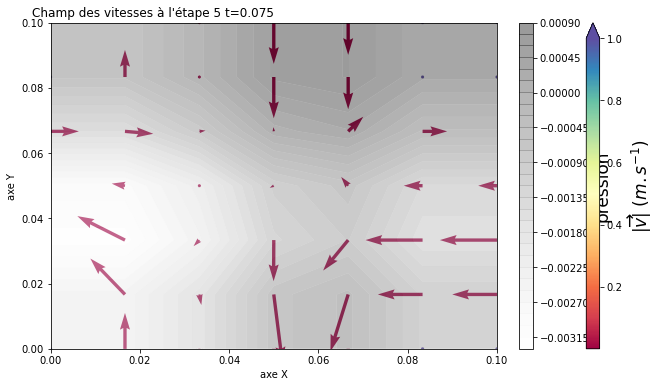

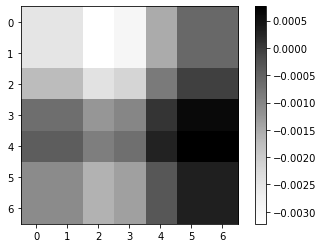

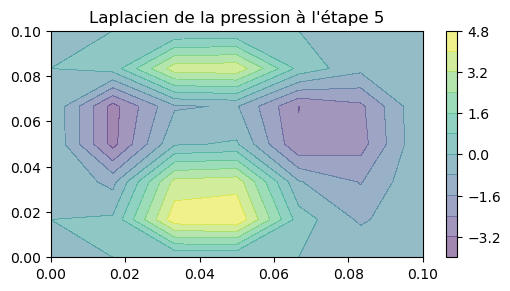

In [18]:
et = 5


x = np.linspace(0, a, imax+2)
y = np.linspace(0, b, jmax+2)
X, Y = np.meshgrid(x, y)
plotter(et,False)
##########################
fig = plt.figure()
c = plt.imshow(P[et],cmap='Greys')
plt.colorbar(c)
##########################
fig = plt.figure(figsize=(6,3), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X,Y, DeltaP[et,:,:], 10, alpha=0.5, cmap=cm.viridis) # inverser
plt.title('Laplacien de la pression à l\'étape '+str(et))
plt.colorbar()
print(np.max(np.abs(U[et])), np.max(np.abs(V[et])) )

In [44]:
div_total = np.zeros(shape=(n+2,imax+2,jmax+2),dtype=np.float)
for et in range(n):
    for i in range(1,imax+1):
        for j in range(1,jmax+1):
            div_total[et][i][j] = div(et,i,j)
np.max(np.abs(div_total))

154.53247868847788

### Ici pour exporter les images

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm


def plotter(et,cl):
    x = np.linspace(0, a, imax+2)
    y = np.linspace(0, b, jmax+2)
    X, Y = np.meshgrid(x, y)
    M = np.hypot(U[et,:,:], V[et,:,:])
    #M = np.log(M)
    M[M == 0] = 1

    fig, ax = plt.subplots(1, 1, figsize=[8,6]) # 11, 7
    plt.xlabel('axe X')
    plt.ylabel('axe Y')
    ax.set_title('Champ des vitesses à l\'étape '+str(et)+' t='+str(round(T[et],3)), horizontalalignment='right')

    axinsR = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    axinsQ = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.2, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)


    # plotting velocity field
    Velocity = ax.quiver(X, Y, U[et,:,:], V[et,:,:], M, pivot='tail', cmap=cm.Spectral)
    barVelocity = fig.colorbar(Velocity, extend='max', orientation='vertical', aspect=10, cax=axinsQ)
    barVelocity.set_label("$\|\overrightarrow{v}\|$ ($m.s^{-1}$)", fontsize=17)

    # plotting pressure field

    Pressure = ax.contourf(X,Y, np.transpose(P[et,:,:]), 30, alpha=0.4, cmap='Greys', antialiased=True) # inverser
    barPressure = fig.colorbar(Pressure, extend='max', cax=axinsR, aspect=20)
    barPressure.set_label("pression", fontsize=17)

    # print(np.max(np.abs(U[et])), np.max(np.abs(V[et])) )
    
    if cl:
        plt.savefig('e'+str(et)+'.jpg', dpi=200, bbox_inches='tight', facecolor='w', edgecolor='w',orientation='portrait')
        plt.close(fig)

In [107]:
for et in range(1,n):
    ploter(et,True)
    if et%5==0:
        print('ok étape '+str(et))
    

ok étape 5
ok étape 10
ok étape 15
ok étape 20
ok étape 25
ok étape 30
ok étape 35
ok étape 40
ok étape 45
ok étape 50
ok étape 55
ok étape 60
ok étape 65
ok étape 70
ok étape 75
ok étape 80
ok étape 85
ok étape 90
ok étape 95
ok étape 100
ok étape 105
ok étape 110
ok étape 115
ok étape 120
ok étape 125
ok étape 130
ok étape 135
ok étape 140
ok étape 145
ok étape 150
ok étape 155
ok étape 160
ok étape 165
ok étape 170
ok étape 175
ok étape 180
ok étape 185
ok étape 190
ok étape 195


Pour créer une vidéo utiliser la commande
`ffmpeg -start_number 1 -i %d.jpg -vcodec mpeg4 test.mp4 -b:v 5000k`

OU `ffmpeg -start_number 1 -i %d.jpg -framerate 25 -c:v libx264 -crf 0 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" output.mp4` en changeant le paramètre `crf` pour la qualité (plus c'est proche de 0, moins ça compresse)

0.2865896710255286

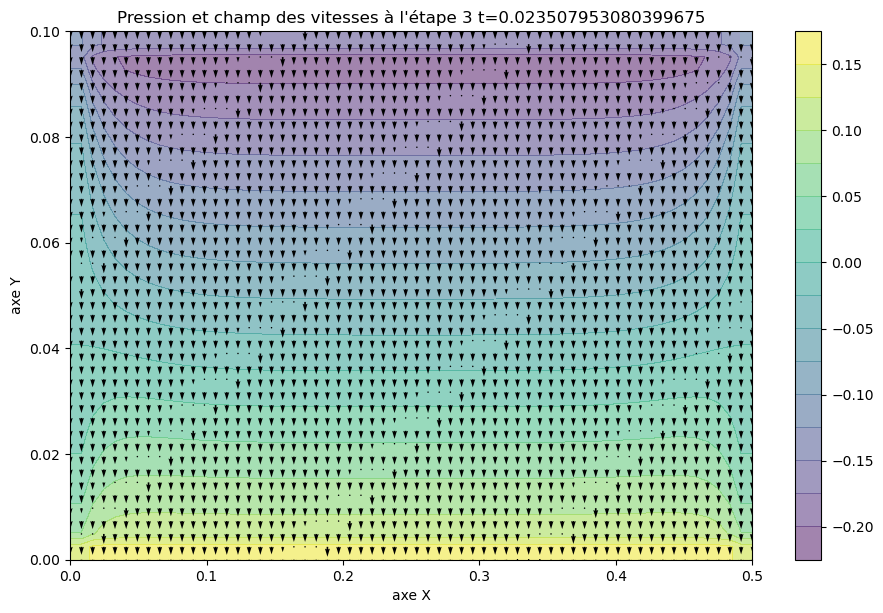

In [163]:
et = 3

M = np.hypot(U[et,:,:], V[et,:,:])
M[M == 0] = 1

fig = plt.figure(figsize=(11,7), dpi=100)
plt.xlabel('axe X')
plt.ylabel('axe Y')
plt.title('Pression et champ des vitesses à l\'étape '+str(et)+' t='+str(T[et]))

# plotting the pressure field as a contour
plt.contourf(X,Y, np.rot90(P[et,:,:],k=3), 15, alpha=0.5, cmap=cm.viridis)  # inverser
plt.colorbar()

# plotting the pressure field outlines
# plt.contour(X, Y, P[et,:,:], cmap=cm.viridis, alpha = 0)




# plotting velocity field
plt.quiver(X, Y, U[et,:,:], V[et,:,:]) 

# lw = 30*M / M.max()
# W = plt.streamplot(X, Y, U[et,:,:], V[et,:,:], density=3, color='black', linewidth=lw)

np.max(np.abs(V[et]))

### Théorie de Kolmogorov et dissipation
La base de la théorie de Kolmogorov énonce que une vision  picturale  de  la  turbulence qui place  la  dissipation  en  chaleur  à  la  fin  d’une  cascadede transferts d’énergie. Ainsi ce qui sera dissipé par la turbulence est entièrement déterminé par les premières étapes qui sont totalement indépendantes de la viscosité. Avec cette idée de cascade, le tauxmoyen de dissipation $\langle \epsilon \rangle$ (puissance dissipée par unité de masse) se détermine par le transfertde l’énergie cinétique $U^2$ des plus gros tourbillons. Ce transfert doit se faire sur la durée de vie du tourbillon, soit sur un temps $\tau = \frac{L}{U}$, on doit donc avoir $\langle \epsilon \rangle \propto \frac{U^3}{L}$. Bien que la viscosité soit responsable de la dissipation, la puissance dissipée dans un écoulement turbulent ne dépend pas de la viscosité !

L'hypothèse de Kolmogorov est la suivante: Pour un nombre de Reynolds $Re \gg 1$, la statistique des mouvements turbulents estuniquement déterminée à partir de $\nu$ et $\langle \epsilon \rangle$.On peut alors construire dimensionnellement à l’aide de ces deux grandeurs, une échelle dite de Kolmogorov,$\eta$ ayant pour vitesse caractéristique $u_\eta$ et temps de caractéristique $\tau_\eta$, telle que:

$\eta = (\frac{\nu^3}{\langle \epsilon \rangle})^{1/4}$

$u_\eta = (\frac{\nu}{\langle \epsilon \rangle})^{1/4}$

$\tau_\eta =\sqrt{\frac{\nu}{\langle \epsilon \rangle}}$

À cette échelle $Re=1$.

L'énergie dissipée à l'échelle $l$ est $\langle \epsilon \rangle = \frac{U_l^3}{l}$ si bien que 

le schéma classique de la turbulence développée est interprétée dans la cascade de Richardson. Chaque structure d’échelle transfert son énergie cinétique $u^2$ pendant unedurée $\tau_l = \frac{l}{u_l}$, soit : $\langle \epsilon \rangle \propto \frac{u_l^2}{\tau_l}$. Une fois transférée l’énergie n’est plus disponible à l’échelle $l$ maisstockée de façon incohérente à des échelles plus petites. En ce sens, l’énergie perdue pour l’échelle $l$ correspond à une dissipation pour cette échelle. Arrivée à l’échelle de Kolmogorov $\eta$, l’énergie ci-nétique de ces plus petites structures de la cascade est dissipée sous forme de chaleur par diffusion visqueuse sur un temps caractéristique $\frac{\eta^2}{\nu}$.


Une des problématiques de la turbulence réside dans le coût prohibitif de la simulation numérique. En effet l’équation de Navier-Stokes doit être capable de reproduire tout type d’écoulement quelquesoit le nombre de Reynolds. On pourrait donc pour ainsi dire tout calculer et tout prévoir. Cependant,pour que ce calcul soit fidèle à la réalité, le schéma numérique devra résoudre toutes les échelles,jusqu’à l’échelle de dissipation de Kolmogorov. D’après la partie précédente, un écoulement de taille $L^3$ devra comporter au moins $\left( \frac{L}{\eta}\right)^3 \sim (Re)^{9/4}$ points de maillage. De même, le rapport des temps ca-ractéristiques entre la grande échelle (de tailleL) et l’échelle de Kolmogorov est $\frac{\tau_l}{\tau_\eta} \sim (Re)^{1/2}$. Ainsi larésolution de cet écoulement pendant un temps caractéristique de la grande échelle (ce qui est large-ment insuffisant pour effectuer des valeurs moyennes) nécessite de résoudre les équations de NavierStokesRe114fois. Ainsi plus le nombre de Reynolds est grand et bien plus la simulation coûtera entemps de calcul. Par exemple, il est inconcevable aujourd’hui de simuler les écoulements autour d’unevoiture ou d’un avion (qui présentent un nombre de Reynolds supérieur à$10^6$).

### Calcul de l'odg du nombre de points nécessaire dans une direction d'espace pour que la simulation

In [16]:
odgacc = 1e-2 # m/s^2
odgt = 1 # s
U = odgacc*odgt
L = .1 # m
nu = 5e-5
r = (U*L/nu)**(3/4) # on calcule ici le rapport L/eta
r

9.457416090031758

In [20]:
eta = L/r
eta # donc idéalement pour retraduire les tourbillons à cette échelle il faudrait discrétiser ça en 10 fois

0.010573712634405642

### Further resources

https://www.thermal-engineering.org/fr/quest-ce-que-lequation-de-navier-stokes-definition/

https://hal-ensta-paris.archives-ouvertes.fr/cel-01228137/file/coursdeturbulence.pdf

https://github.com/barbagroup/CFDPython et https://piazza.com/bu/spring2013/me702/resources et https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf (a guide to writing your first CFD solver)


Voir aussi "Real time fluid dynamics for games" https://www.youtube.com/watch?v=alhpH6ECFvQ

et les liens:
💻 Code: https://thecodingtrain.com/CodingChal...​

Links discussed in this video:
🔗 GitHub Thread: https://github.com/CodingTrain/Rainbo...​
🔗 Real-Time Fluid Dynamics for Games by Jos Stam: http://www.dgp.toronto.edu/people/sta...​
🔗 MSAFluid: https://www.memo.tv/msafluid/​
🔗 Lily Pad: https://github.com/weymouth/lily-pad​
🔗 Fluid Simulation for Dummies by Mike Ash: https://mikeash.com/pyblog/fluid-simu...​
🎥 Why Laminar Flow is AWESOME - Smarter Every Day 208: https://youtu.be/y7Hyc3MRKno​
🎥 What DO we know about turbulence? by 3Blue1Brown: https://youtu.be/_UoTTq651dE​
🎥 Perlin Noise: https://youtu.be/Qf4dIN99e2w

en dessous de cettte vidéo https://www.youtube.com/watch?v=alhpH6ECFvQ

ainsi que cet article qui cite le livre que j'ai utilisé https://www5.in.tum.de/pub/bartels_idp_14.pdf
et cette vidéo https://www.youtube.com/watch?v=qsYE1wMEMPA qui parle d'uns simu en compressible

In [ ]:
set1G(0)
x = np.linspace(0, a, imax+2)
y = np.linspace(0, b, jmax+2)
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(5,4), dpi=100)
plt.quiver(X, Y, Gx, Gy)
print(np.abs(Gx).max(), np.max(np.abs(Gy)))